In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats  
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.metrics import brier_score_loss, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

seed = 1984

# Overview

The assignment for the challenge was to fill in the missing data in the test set using the train set. 

To do this, I train two classification models:
- A binary classification model to estimate the *Value* feature -which I understand would be the target for a churn model-
- A multi-class classification model to estimate the *Status* feature, which I assume corresponds to the company's status: Non profit, private or publicly traded.

I assume:  
- each website corresponds to a company
- the state feature corresponds to the state where the company is located
- revenue is the company's revenue in the previous year

# Load data

In [2]:
path = os.path.dirname(os.getcwd())
train_set = pd.read_csv(path + '/1 - data/case_study_training.csv') 
test_set  = pd.read_csv(path + '/1 - data/case_study_testing.csv')

# Data exploration

In [20]:
def missing_zero_values_table(df):
    """
    Parameters:
        df: dataframe to use
    
    Returns:
        mz_table: table with a count of blank and missing values 
                    and these values as percentage of the total
    """
    no_val = (df == ' ').astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([no_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(columns = {0 : 'Blank Values', 1 : 'Missing Values',
                                          2 : '% of Total Values'})
    mz_table = mz_table.sort_values('% of Total Values', ascending=False).round(1)

    return mz_table

In [21]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   City     2000 non-null   object
 1   Website  2000 non-null   object
 2   Revenue  2000 non-null   object
 3   Status   2000 non-null   object
 4   Value    2000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


In [22]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   City     2000 non-null   object 
 1   Website  2000 non-null   object 
 2   Revenue  2000 non-null   object 
 3   Status   0 non-null      float64
 4   Value    0 non-null      float64
dtypes: float64(2), object(3)
memory usage: 78.3+ KB


## Missing values

In [23]:
missing_zero_values_table(train_set)

,Blank Values,Missing Values,% of Total Values
City,0,0,0.0
Website,0,0,0.0
Revenue,0,0,0.0
Status,0,0,0.0
Value,0,0,0.0


In [23]:
missing_zero_values_table(test_set)

,Blank Values,Missing Values,% of Total Values
Status,0,2000,100.0
Value,0,2000,100.0
City,0,0,0.0
Website,0,0,0.0
Revenue,0,0,0.0


There are no blank or missing  values in the columns in either dataset, so there is no need to either discard or fill these columns. 

## Duplicates

In [26]:
'No duplicates' if len(train_set)==len(train_set.drop_duplicates()) else 'Duplicates'

'No duplicates'

In [119]:
print('Unique Websites:',len(train_set.Website.unique()))

Unique Websites: 1993


In [120]:
train_set.Website.value_counts()[:10]

https://bacoproperties.com/                 2
https://www.cornerstonesolutionsusa.com/    2
http://homeinstead.com                      2
http://redchamber.com/                      2
https://www.seniorhelpers.com/              2
https://gourmetglatt.com/                   2
https://www.tmctrans.com/                   2
http://www.haciendafiesta.com               1
https://www.sensivahealth.com/              1
https://mystiqueofmaine.com/                1
Name: Website, dtype: int64

In [122]:
presumed_duplicates = [
    'https://bacoproperties.com/', 'https://www.cornerstonesolutionsusa.com/',
    'http://homeinstead.com', 'http://redchamber.com/', 
    'https://www.seniorhelpers.com/', 'https://gourmetglatt.com/',
    'https://www.tmctrans.com/']

train_set[train_set.Website.isin(presumed_duplicates)].sort_values(by='Website')

,City,Website,Revenue,Status,Value
372,Daytona Beach,http://homeinstead.com,"$500,001 to $7,500,000",Private,0
845,"Erie, PA",http://homeinstead.com,Undefined,Private,0
728,Vernon,http://redchamber.com/,"$100,000,001 or Above",Private,0
1440,Vernon,http://redchamber.com/,Undefined,Private,0
798,San Francisco,https://bacoproperties.com/,"$500,001 to $7,500,000",Private,1
927,San Francisco,https://bacoproperties.com/,Undefined,Private,1
213,Cedarhurst,https://gourmetglatt.com/,Undefined,Non Profit,0
695,Lakewood,https://gourmetglatt.com/,Undefined,Private,0
197,Atlanta,https://www.cornerstonesolutionsusa.com/,Undefined,Private,0
1369,Chamblee,https://www.cornerstonesolutionsusa.com/,Undefined,Private,0


# Data cleaning

There are some websites that are duplicated, as they have two different Revenues assigned to them. I assume this could be a timing issue (it was first un an Undefined category and later modified). <br>
For these we'll keep the row where the Revenue is not *Undefined* or *Below 1*. <br>

Some websites appear twice but have different cities and statuses. With the available informaiton I can't see which of these is the correct value. Given this, I will remove them.

In [3]:
def create_feature(df):
    df['Revenue'] = np.select([df['Revenue'] == 'Below $1',
                               df['Revenue'] == '$1 to $500,000',
                               df['Revenue'] == '$500,001 to $7,500,000',
                               df['Revenue'] == '$7,500,001 to $25,000,000',
                               df['Revenue'] == '$25,000,001 to $100,000,000',
                               df['Revenue'] == '$100,000,001 or Above', 
                               df['Revenue'] == 'Undefined'],                                   
                               ['a. Below 1', 'b. 1 to 500K',  
                                'c. 500K to $7.5M','d. 7.5M to 25M', 
                                'e. 25M to 100M', 
                                'f. 100M or above', 'g. Undefined'])
    
    return df

In [4]:
### Duplicated websites
duplicated_websites = [
    'https://bacoproperties.com/', 'http://homeinstead.com',
    'http://redchamber.com/', 'https://www.seniorhelpers.com/', 
    'https://www.tmctrans.com/', 'https://gourmetglatt.com/', 
    'https://www.cornerstonesolutionsusa.com/']
rev_duplicates = ['g. Undefined', 'a. Below 1']

# removing duplicates 
idx_websites = train_set[(train_set['Website'].isin(duplicated_websites)) & 
                         (train_set['Revenue'].isin(rev_duplicates))].index
train_set.drop(idx_websites, inplace=True)

## Revenue 
# adding letters for better visualization
train_set = create_feature(train_set)
test_set = create_feature(test_set)

# EDA

In [8]:
def make_barplot(df, x_var, rot = False):
    '''
    Parameters: 
        df : df to use
        x_var : feature used to group 
        y_var: feature used to create the aggregation needed
        aggregation : aggregation to use to aggregate var_agg
        rot : False if X axis should not be rotated 
    
    Returns : 
        barchart mean of var_group by var_mn
    '''
    # Grouping to plot
    df_gr = round(df[x_var].value_counts(normalize=True),
                  2).rename_axis(x_var).reset_index(name='pct_counts').sort_values(by=x_var)

    # Gráfico
    sns.set_style("white")
    plt.figure(figsize=(16,8))
    sns.set_context("paper", font_scale=1.3)
    
    plot = sns.barplot(x=x_var, y='pct_counts', 
                       data=df_gr, palette="Blues")
    
    plot.bar_label(plot.containers[0], label_type='edge')
    
    if rot : 
        for item in plot.get_xticklabels():
            item.set_rotation(90)
    plt.show()

## Univariate
*Number of Websites per feature*

### Train

In [10]:
# Count websites per city
df_gr = train_set.groupby(['City'], as_index=False)['Website'].agg('count')
len(df_gr[df_gr.Website != 1])

289

We can see most cities have only 1 website associated to them. 

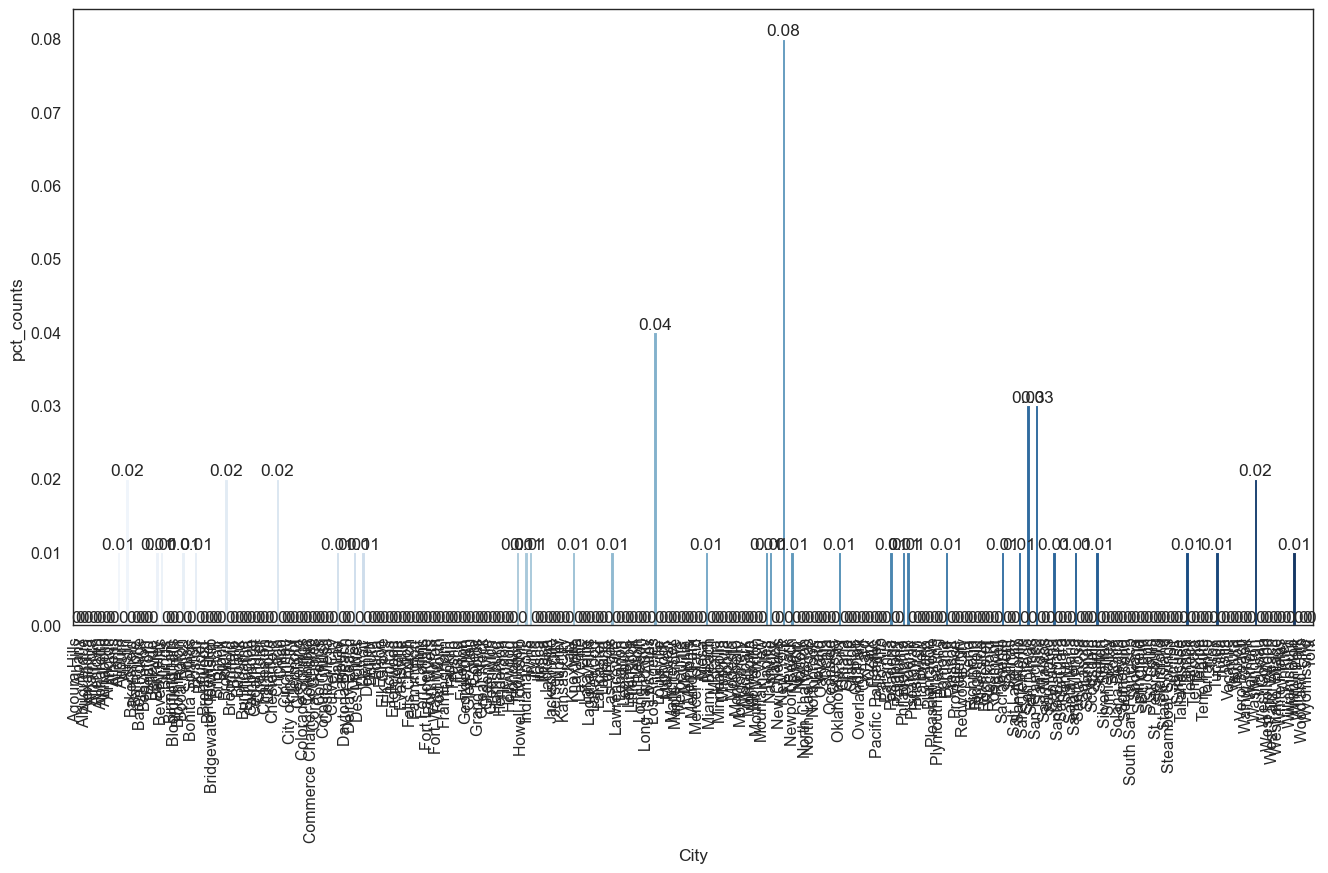

In [11]:
# cities with more than one website
multiple_websites = df_gr[df_gr.Website != 1].City.tolist()
make_barplot(train_set[train_set.City.isin(multiple_websites)], 
             x_var = 'City', rot=True)

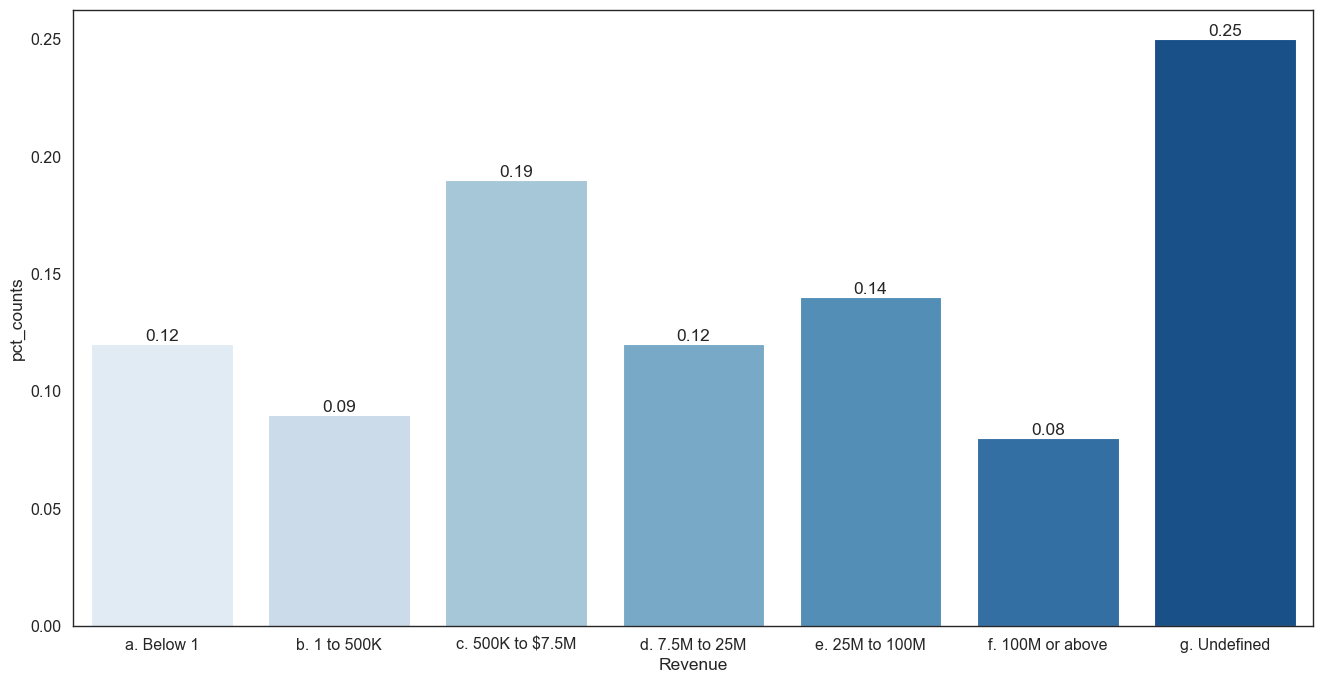

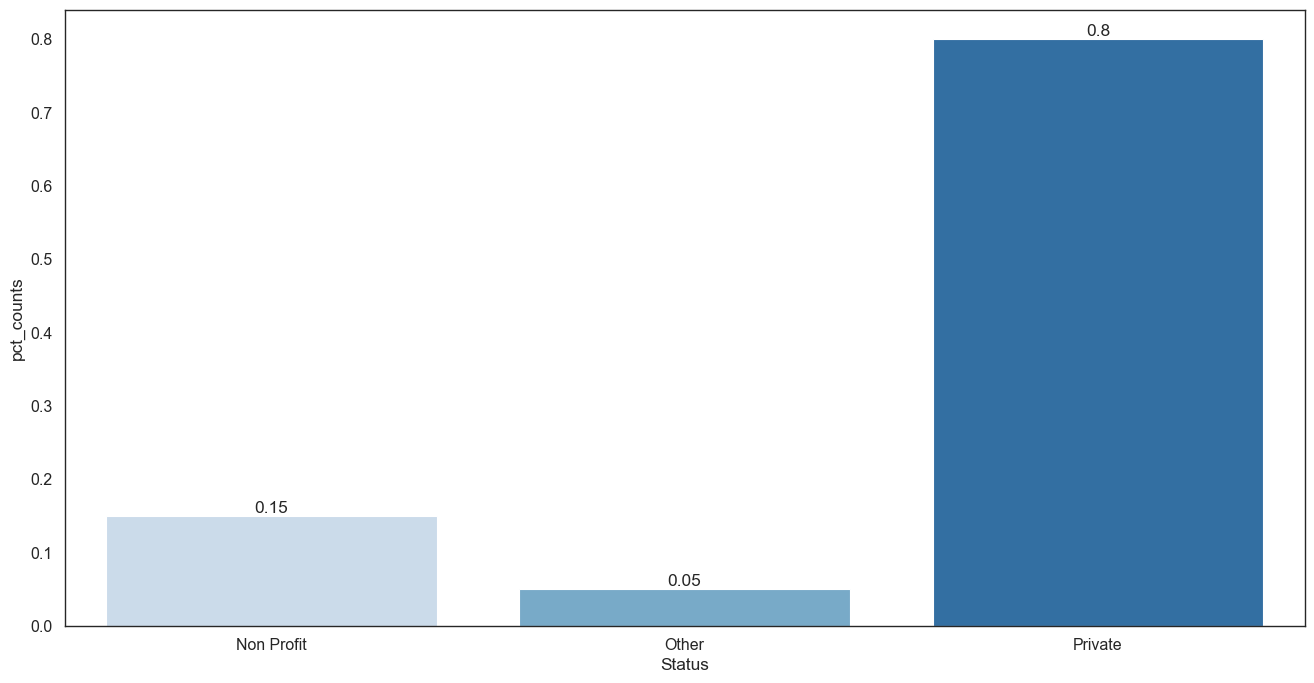

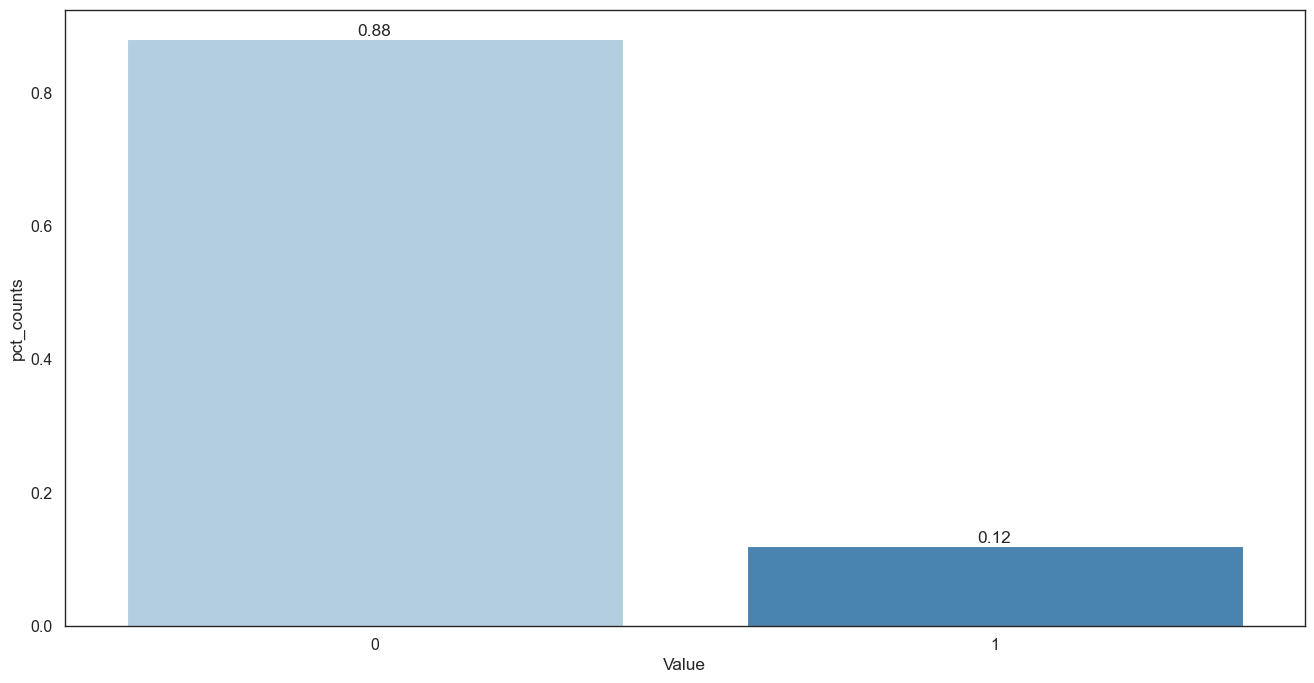

In [12]:
cols = ['Revenue', 'Status', 'Value']
for col in cols: 
    make_barplot(train_set, col)

Both Status and value (missing columns in the test set) are unbalanced. <br>
- 80% of websites are private (5% are *other*, 15% are *Non Profit*), and the value is mostly 0 (only 11% of websites are 1). 
- Only 12% of *value* are labeled 1.

### Test

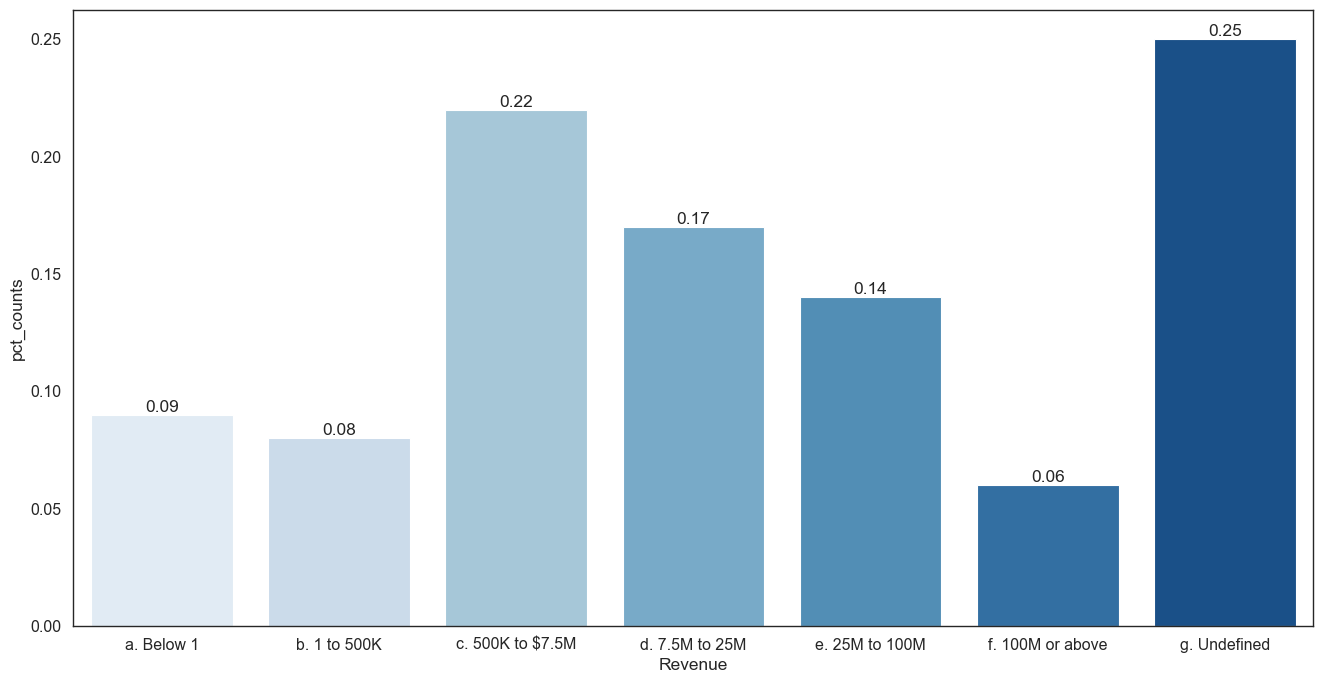

In [13]:
cols = ['Revenue']
for col in cols: 
    make_barplot(test_set, col)

We can see the distribution of the train and test sets are not very dissimilar regarding the *Revenue* feature.

## Bivariate

In [15]:
def pct_bar_labels(ax1):
    plt.ylabel('Relative Frequency (%)')
    plt.xticks(rotation = 0)
    plt.yticks([])   
    # Set individual bar lebels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha = 'center', va = 'center', xytext = (0, 7), 
        textcoords = 'offset points', fontsize = 10, color = 'black')

def composition(cat, cat_target): 
    """
    Parameters: 
        cat: categorical feature to plot
        cat_target: target feature
        
    Returns: 
        plot with % of observations by category, according to target value
    """
    pct_cat_grouped_by_cat_target = round(pd.crosstab(index = cat, 
                                                      columns = cat_target, 
                                                      normalize = 'index')*100, 2)

    # Plot relative freq of target by a categorical variable
    sns.set(rc={'figure.figsize':(14,8)})
    
    ax1 = pct_cat_grouped_by_cat_target.plot.bar(color = ['darkcyan', 'mediumaquamarine', 'paleturquoise'])
    plt.title('Percentage target by %s' %cat.name)
    pct_bar_labels(ax1)
    plt.show()
    
def chi_square(cat, cat_target):
    cat_grouped_by_cat_target = pd.crosstab(index = cat, columns = cat_target)
    chi_sq_value = stats.chi2_contingency (cat_grouped_by_cat_target)[0]
    p_value = stats.chi2_contingency (cat_grouped_by_cat_target)[1]
    exp_vale = stats.chi2_contingency (cat_grouped_by_cat_target)[3]
    
    return chi_sq_value, p_value, exp_vale

### Churn 

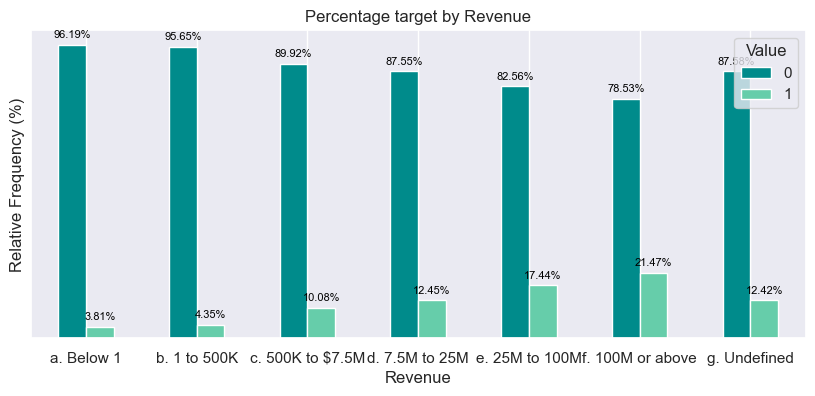

In [21]:
composition(train_set['Revenue'], train_set['Value'])

Revenue seems to have a relationship with the Value column. 

**Chi-square Test:** This is a test of independence. It tests if there is a significant relationship between two categorical variables. It tests the data as a whole, which means that one will not be able to tell which levels (categories) of the variables are responsible for the relationship.

    - H0 (Null Hypothesis): There is no relationship between variable one and variable two.

    - H1 (Alternative Hypothesis): There is a relationship between variable 1 and variable 2.

If the p-value is significant (less than 0.05), you can safely reject H0. We need also to check that the expected cell frequencies are greater than or equal to 5. 

In [69]:
print('Revenue - Value')
print('')
print('Chi-square value: ', chi_square(train_set['Revenue'], train_set['Value'])[0])
print('p-value :', chi_square(train_set['Revenue'], train_set['Value'])[1])
print('expected frequencies:', chi_square(train_set['Revenue'], train_set['Value'])[2])

Revenue - Value

Chi-square value:  49.5298573096572
p-value : 5.839958553034693e-09
expected frequencies: [[209.3895  27.6105]
 [162.564   21.436 ]
 [341.9145  45.0855]
 [219.9915  29.0085]
 [248.2635  32.7365]
 [144.0105  18.9895]
 [440.8665  58.1335]]


It seems the p value is less than 0.05 and the expected values are all over 5, thus we can reject H0 and conclude there is a relationship between the two features. 

### Multi-class target

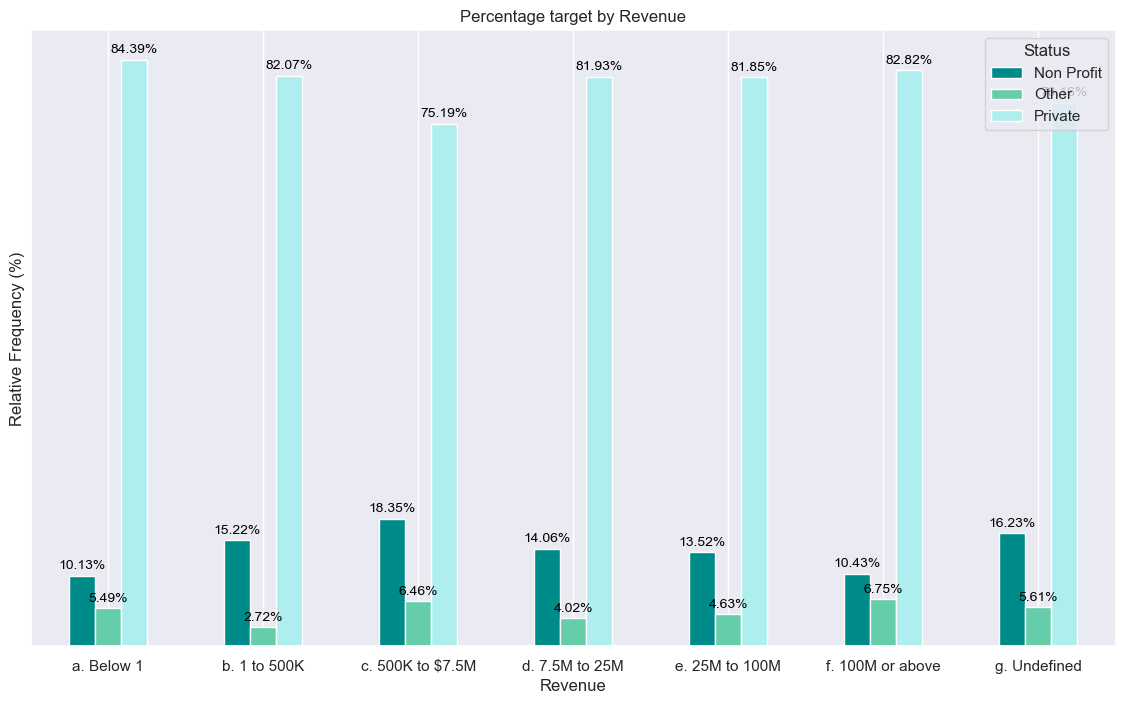

In [17]:
composition(train_set['Revenue'], train_set['Status'])

As opposed to the previous feature, there doesn't appear to be a linear relationship between these two features.

In [70]:
print('Revenue - Status')
print('')
print('Chi-square value: ', chi_square(train_set['Revenue'], train_set['Status'])[0])
print('p-value :', chi_square(train_set['Revenue'], train_set['Status'])[1])
print('expected frequencies:', chi_square(train_set['Revenue'], train_set['Status'])[2])

Revenue - Status

Chi-square value:  17.55802467704279
p-value : 0.1297842104203632
expected frequencies: [[ 34.839   12.4425 189.7185]
 [ 27.048    9.66   147.292 ]
 [ 56.889   20.3175 309.7935]
 [ 36.603   13.0725 199.3245]
 [ 41.307   14.7525 224.9405]
 [ 23.961    8.5575 130.4815]
 [ 73.353   26.1975 399.4495]]


It seems the p value is higher than 0.05, thus we can not reject H0. This confirms the intuition that there isn't a relationshop between the two features. 

# Models

## Functions

In [4]:
def class_report(y_pred_train, y_train, y_pred_test, y_test):
    """ 
    y_pred_train: predicted y values for train dataset
    y_train: ground truth for train dataset
    y_pred_test: predicted y values for test dataset
    y_test: ground truth for test dataset

    Returns: classification reports for train and test
    """
    print('TRAIN Classification Report')
    print('-----------------------------------------------')
    print(classification_report(y_train, y_pred_train))
    print('TEST Classification Report')
    print('-----------------------------------------------')
    print(classification_report(y_test, y_pred_test))

def feature_importance(model, X_train, top_features):
    """ 
    model: model from which you want to get the feature importance
    X_train : train set used to train the model
    top_features: number of features you want to see in the graph

    Returns: feature importance graph
    """
    plt.figure(figsize = (6,6))
    feat_importances = pd.DataFrame({'columns': X_train.columns, 
                            'importance': model.feature_importances_}).sort_values('importance',
                                                                                       ascending=False)
    sns.set_context("paper", rc={"font.size":10, "xtick.labelsize":10,
                                 "ytick.labelsize":10, "axes.labelsize":10}) 
    sns.barplot(x="importance", y="columns", data = feat_importances.iloc[:top_features,:])
    plt.show()

def create_dummy_clf(x_train, y_train,
                    x_test, y_test):

    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(x_train, y_train)

    y_pred_train_dumm = dummy_clf.predict(x_train)
    y_pred_test_dumm = dummy_clf.predict(x_test)
    
    class_report(y_pred_train_dumm, y_train, 
                  y_pred_test_dumm, y_test)

def split_data(df, test_size, target):
    """ 
    df        : dataframe to split 
    test_size : percentage of dataset to use for test set (float)
    target    : target feature name (str)

    Returns   : train and test sets split into x and y
    """
    # Train - test original
    X_train, X_test = train_test_split(df, test_size=test_size, 
                                       random_state = seed, 
                                       stratify = df_dummies[target])
    y_train = X_train[target]
    y_test = X_test[target]
    
    x_train = X_train.drop([target], axis=1)
    x_test = X_test.drop([target], axis=1)
    
    return x_train, x_test, y_train, y_test

## Churn model

I fit a small classifier to see how a model does with this data, and a dummy classifier that only predicts the most frequent category to use as baseline.<br>
As there are few features, there would probably not be much difference between a RF classifier and other algorithms.

### Train test split

In [11]:
# select features to use and convert to dummies
cols = ['City', 'Revenue', 'Value']

df_dummies = pd.get_dummies(train_set.loc[:,cols])

x_train, x_test, y_train, y_test = split_data(df_dummies, 
                                              test_size = 0.2, 
                                              target = 'Value')

### Dummy classifier

In [41]:
create_dummy_clf(x_train, y_train, x_test, y_test)

TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1406
           1       0.00      0.00      0.00       186

    accuracy                           0.88      1592
   macro avg       0.44      0.50      0.47      1592
weighted avg       0.78      0.88      0.83      1592

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       353
           1       0.00      0.00      0.00        46

    accuracy                           0.88       399
   macro avg       0.44      0.50      0.47       399
weighted avg       0.78      0.88      0.83       399



### RF

In [12]:
# Train model
rfc = RandomForestClassifier(random_state=seed, n_estimators=100, max_depth=10)
rf_mdl = rfc.fit(x_train, y_train)

y_pred_train_rf = rf_mdl.predict(x_train)
y_pred_test_rf = rf_mdl.predict(x_test)

**SHAP values**

SHAP values are used to see how different features affect the prediction.
Each point represents the value of that feature for that observation. The point's color shows whether the feature's value was high or low (colors closer to hot pink indicate a higher value, colors closer to blue, a lower one), and its location in the horizontal line shows that the feature's impact in the model output for the class that is being evaluated.

Ej: a pink point located to the left means thathe t feature had a higher value, and that increased thprobabilityty that that observation would correspond to that category.


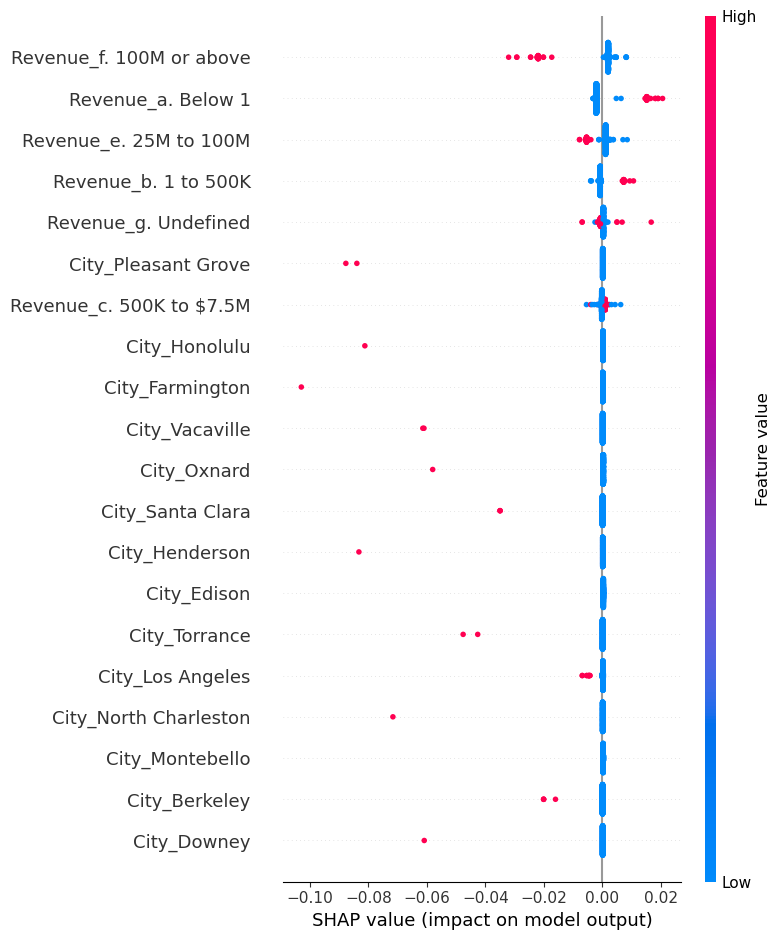

In [14]:
explainer_rf = shap.TreeExplainer(rf_mdl)
shap_values_rf = explainer_rf.shap_values(x_test[sorted(x_test.columns)])

shap.summary_plot(shap_values_rf[0], x_test)

We can see that companies that have a revenue of over 100M and between 25 and 100M have a lower chance of being predicted as 1.<br>
The opposite is true for companies with a revenue under $1. This makes sense if we think of this as the revenue from the past year: a company that has had a lower revenue might be more likely to churn. 

In [147]:
print('Scores')
scoring=['accuracy','precision_macro','recall_macro']
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) #Define evaluation procedure 

scores_ori = cross_validate(rfc, x_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_ori['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_ori['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_ori['test_recall_macro']))
print('')

Scores
Mean Accuracy: 0.8832
Mean Precision: 0.4416
Mean Recall: 0.5000



In [57]:
class_report(y_pred_train_rf, y_train, 
              y_pred_test_rf, y_test)

TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1406
           1       0.00      0.00      0.00       186

    accuracy                           0.88      1592
   macro avg       0.44      0.50      0.47      1592
weighted avg       0.78      0.88      0.83      1592

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       353
           1       0.00      0.00      0.00        46

    accuracy                           0.88       399
   macro avg       0.44      0.50      0.47       399
weighted avg       0.78      0.88      0.83       399



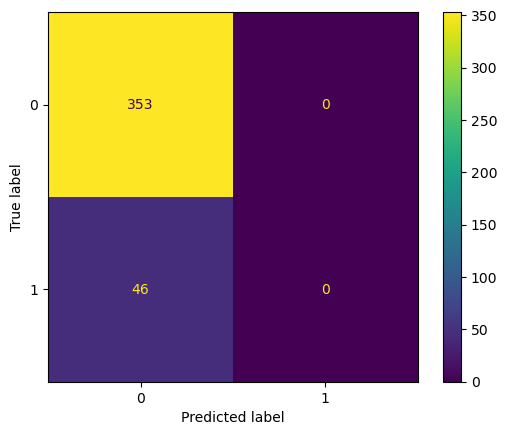

In [9]:
CM = confusion_matrix(y_test, y_pred_test_rf)
ConfusionMatrixDisplay(CM).plot()
plt.show()

We cam see the model is just predicting the most frequent category -this is why the results are exactly the same as the dummy predictor-, and that the features are not giving enough explanatory value to the model, i.e. the model is underfitting the data. 

## Multi-class classification model

I fit a small classifier to see how a model does with this data, and a dummy classifier that only predicts the most frequent category to use as baseline.

### Train test split

In [5]:
# select features to use and convert to dummies
cols = ['City', 'Revenue']

df_dummies = pd.get_dummies(train_set.loc[:,cols])
# factorize target
factor = pd.factorize(train_set['Status'])
# save factor names
definitions = factor[1]
df_dummies['status_labels'] = factor[0]

# split into train and test
x_train_mc, x_test_mc, y_train_mc, y_test_mc = split_data(df_dummies, 
                                              test_size = 0.2, 
                                              target = 'status_labels')

### Dummy classifier

In [43]:
create_dummy_clf(x_train_mc, y_train_mc,
                x_test_mc, y_test_mc)

TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.80      1.00      0.89      1275
           2       0.00      0.00      0.00       234

    accuracy                           0.80      1592
   macro avg       0.27      0.33      0.30      1592
weighted avg       0.64      0.80      0.71      1592

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.80      1.00      0.89       319
           2       0.00      0.00      0.00        59

    accuracy                           0.80       399
   macro avg       0.27      0.33      0.30       399
weighted avg       0.64      0.80      0.71       399



### RF 

In [6]:
# Train model
rfc = RandomForestClassifier(random_state=seed, n_estimators=100, max_depth=10)
rf_mdl_mc = rfc.fit(x_train_mc, y_train_mc)

y_pred_train_rf_mc = rf_mdl_mc.predict(x_train_mc)
y_pred_test_rf_mc = rf_mdl_mc.predict(x_test_mc)

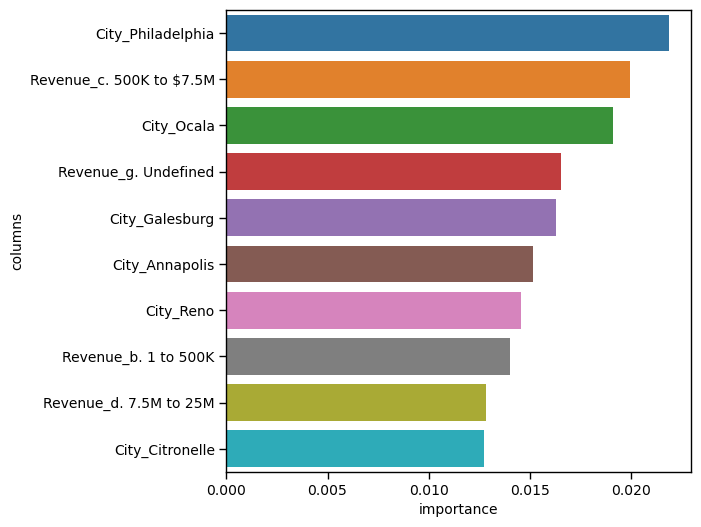

In [53]:
feature_importance(rf_mdl_mc, x_train_mc, 10)

In [101]:
class_report(y_pred_train_rf_mc, y_train_mc, 
              y_pred_test_rf_mc, y_test_mc)

TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.80      1.00      0.89      1275
           2       0.00      0.00      0.00       234

    accuracy                           0.80      1592
   macro avg       0.27      0.33      0.30      1592
weighted avg       0.64      0.80      0.71      1592

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.80      1.00      0.89       319
           2       0.00      0.00      0.00        59

    accuracy                           0.80       399
   macro avg       0.27      0.33      0.30       399
weighted avg       0.64      0.80      0.71       399



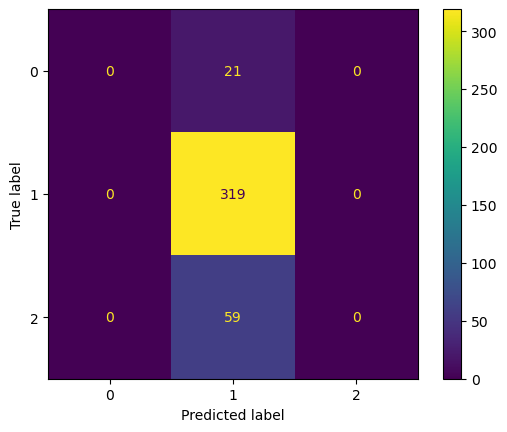

In [12]:
CM = confusion_matrix(y_test_mc, y_pred_test_rf_mc)
ConfusionMatrixDisplay(CM).plot()
plt.show()

We cam see the model is just predicting the most frequent category -this is why the results are exactly the same as the dummy predictor-, and that the features are not giving enough explanatory value to the model, i.e. the model is underfitting the data. 

# Results & next steps

Both models have roughly the same conclusions and results, so I will do them jointly. 

The main metric we consider in both models is *recall*, as we're most interested in identifying all those that positive. <br>
This is particularly important in the churn model, where it's not as important to have false positives but to try to capture as many of the positive class as possible to prevent churn. <br>

The RF results are exactly the same as the dummy model in both cases. This means: 

- the models are just predicting the most frequent category
- the features are not giving enough explanatory value to the model, i.e. the model is underfitting the data. 

Some things that could be tried to improve the results: <br>
1) for each model, it would be necessary to have more information:
     - for the churn model: about the company such as activity, number of years it's a client, if there's information about the number of employees and its variation over time, the company's history in counterpart, etc.
     - for the multi-class model: also information about the company such as the sector it's in, investment rounds maybe? and information related to that. 
2) Data on those companies whose revenue is "Undefined" would also help, as currently, almost 25% of companies fall into this category.
3) reduce dimensionality in cities, as it can't be used as is. There are too many cities for this to be used as a feature. It would be useful if it could be at a higher level, maybe jurisdiction or even state. <br>
4) If the models are still underfitting with an RF classifier with the new features, it could benefit to try a different algorithm:
    - for the churn model it could be an XGBoost model
    - for the multi-class model it could be an SVM model 
5) Some over/under sampling could be included to try to get a better prediction for the target, but this would likely not be fruitful if we don't add predictive features. 